In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas  # noqa
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.rc('figure', figsize=(16,9), dpi=100)
pd.options.plotting.backend = 'holoviews'

# Data
The data was collected by the GDAX (coinbase pro) cryptocurrency exchange, is sampled with frequency of 5s seconds from 10:15:40 to 12:27:40 on 5th February 2021.

* Sample frequency $\Delta t$: $5$s

* Instrument: BTC-USD

* No. of measurements : $\approx$ 1500 

Trades dataset contains the mean price and the total volume and count for the sell/buy orders filled during time interval 
$[t, t + \Delta t]$.  
Data is then downsampled at 10s resolution, in attempt to reduce noise. Hence from now on $\Delta t = 10s$

In [2]:
trades = pd.read_csv('data_5s/trades.csv')
trades.fillna(0,inplace=True)
trades.timestamp = pd.to_datetime(trades.timestamp)
trades.head()

trades = trades.set_index('timestamp').resample('10s').apply({'sell_avg_price': np.mean,
                                                             'sell_qty':np.sum,
                                                             'sell_count':np.sum,
                                                             'buy_avg_price':np.mean,
                                                             'buy_qty':np.sum,
                                                             'buy_count':np.sum,
                                                             })
trades.head()

,sell_avg_price,sell_qty,sell_count,buy_avg_price,buy_qty,buy_count
timestamp,,,,,,
2021-02-05 10:15:40+01:00,0.000000,0.000000,0,0.000,0.000000,0
2021-02-05 10:15:50+01:00,18836.740000,0.018764,3,18837.680,0.053069,1
2021-02-05 10:16:00+01:00,18844.184167,0.176564,6,18843.680,0.063322,4
2021-02-05 10:16:10+01:00,0.000000,0.000000,0,18849.615,0.036954,2
2021-02-05 10:16:20+01:00,18849.195000,0.006232,2,0.000,0.000000,0


In [3]:
df = trades[['sell_qty','buy_qty']].copy()
df['sell_qty'] = -df['sell_qty']
df.plot(y=['buy_qty', 'sell_qty']).opts(height=500, width=800, title='Signed volume of trades')

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

The book dataset contains the snapshot of the order book (only the top bid/ask level) at time $t$.
`ask_count`, `bid_count` are the number of outstanding orders, while `ask_size`, `bid_size` are the actual volumes available at `ask` and `bid`

In [4]:
book = pd.read_csv('data_5s/orderbook.csv')
book.timestamp = pd.to_datetime(book.timestamp)
book = book.set_index('timestamp').resample('10s').apply({'bid': np.mean, 
                                                          'ask': np.mean,
                                                          'bid_size': np.sum,
                                                          'ask_size': np.sum,
                                                          'bid_count': np.sum,
                                                          'ask_count': np.sum
                                                         })
book.head()

,bid,ask,bid_size,ask_size,bid_count,ask_count
timestamp,,,,,,
2021-02-05 10:15:40+01:00,37677.225,37677.240,0.529085,2.613274,3,3
2021-02-05 10:15:50+01:00,37677.120,37678.795,0.525400,0.023272,2,2
2021-02-05 10:16:00+01:00,37706.960,37707.630,2.214277,0.585400,5,2
2021-02-05 10:16:10+01:00,37688.705,37694.355,1.241279,0.430948,2,2
2021-02-05 10:16:20+01:00,37697.280,37700.550,1.099400,0.126677,4,2


# Analysis

midprice = $.5 \times$ (ask + bid)

In [5]:
book['mid'] = .5*(book.ask + book.bid)

In [6]:
df = book[['ask_size','bid_size','mid']].copy()
df['ask_size'] = - df['ask_size']
( df.mid.plot(label='mid price') + df.plot(y=['bid_size','ask_size'], label='volume at the top of the order book')).opts(width=800, height=500, shared_axes=True).cols(1)


:Layout
   .Curve.Mid_price                               :Curve   [timestamp]   (mid)
   .NdOverlay.Volume_at_the_top_of_the_order_book :NdOverlay   [Variable]
      :Curve   [timestamp]   (value)

#### Target and first difference in midprice comparison

Quantity to estimate ($a_t$ = ask, $b_t$ = bid)

$$
y_t = [b_t - a_{t-1}]_+ - [a_t - b_{t-1}]_-
$$

aka `target`, highly correlated with the first order mid price variation `dmid` ($= y_t - y_{t-1}$).  
They both exhibit a heavy peaked distribution, expecially `target`.    

Only first order lag $y_{t-1}$ presents significant (at 95% confidence level) autocorrelation with $y_t$

In [7]:
book['spread'] = book.ask - book.bid
book['dspread'] = book.spread.diff()
book['dmid'] = book.mid.diff()
book['target'] = np.maximum(book.bid.shift() - book.ask,0) + np.minimum(book.ask.shift() - book.bid, 0)
(
    book.dropna().plot(y='target',x='timestamp',kind='scatter') + 
    book.dropna().plot(y='dmid',x='timestamp') 
).opts(width=800, height=500).cols(1) 

:Layout
   .Scatter.I :Scatter   [timestamp]   (target)
   .Curve.I   :Curve   [timestamp]   (dmid)

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

df = book[['target','dmid']].copy().dropna()
# df.set_index('timestamp',inplace=True)
df['dmid'] = sc.fit_transform(df.dmid.values.reshape(-1,1))
df['target'] = sc.fit_transform(df.target.values.reshape(-1,1))
# df['target_t'] = df.target.apply(lambda x : - .85* np.abs(x) *np.tanh(x))

df.plot(x='target',y=['dmid'],kind='scatter',alpha=.5).opts(width=800, height=500)

:Scatter   [target]   (dmid)

In [9]:
df.hvplot.hist(y=['target','dmid'],legend='top',alpha=.5,bins=50, xlabel='USD/BTC').opts(width=800,height=500, title='Histogram')

:NdOverlay   [Element]
   :Histogram   [dmid]   (dmid_count)

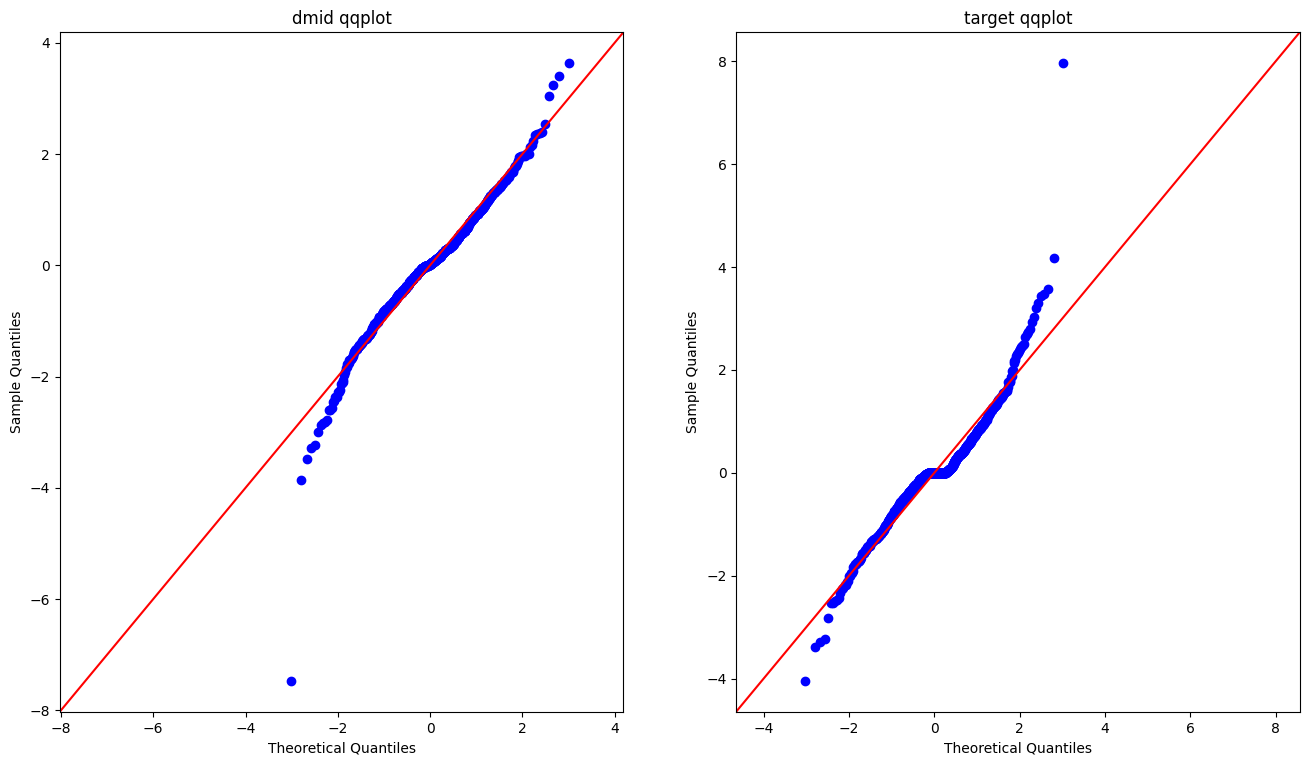

In [10]:
fig, ax = plt.subplots(1,2)
_ = sm.qqplot(df.dmid.dropna(), fit=True, line="45", ax=ax[0])
_ = sm.qqplot(df.target.dropna(), fit=True, line="45", ax=ax[1])
_ = ax[0].set_title('dmid qqplot')
_ = ax[1].set_title('target qqplot')

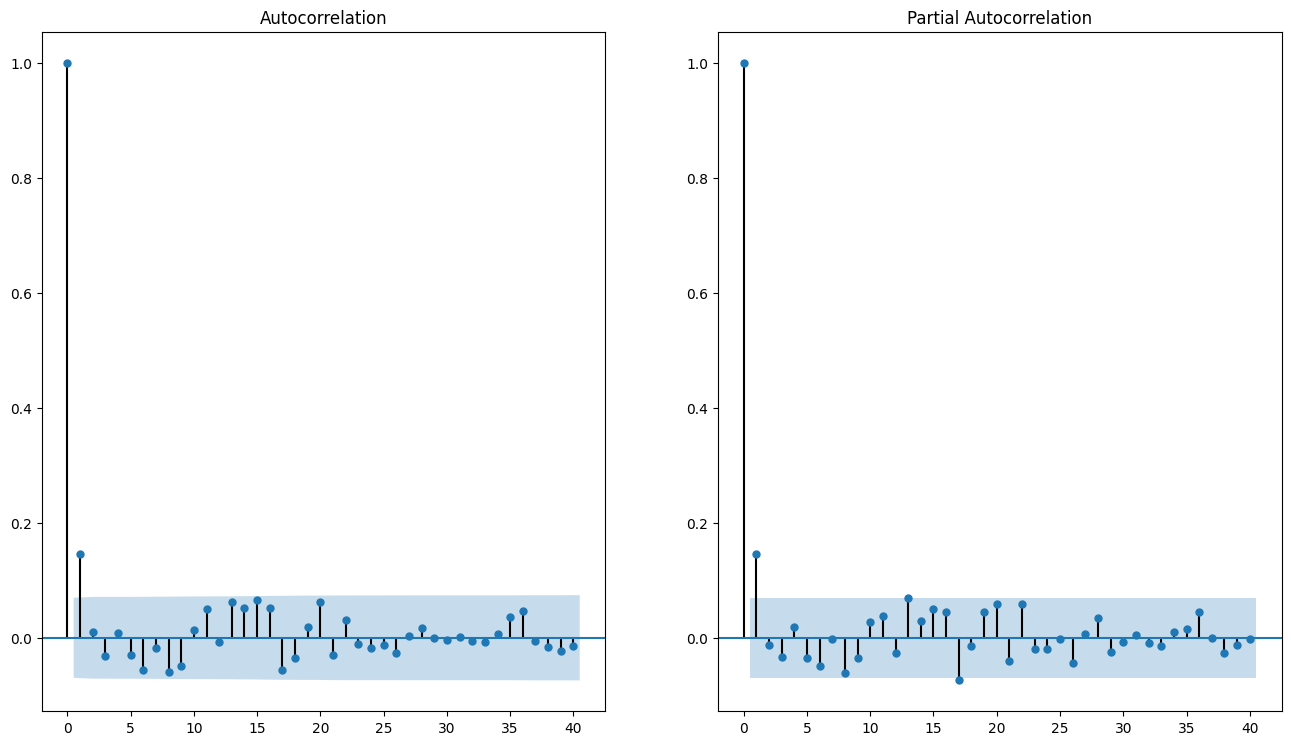

In [11]:
# target acf / pacf plots
fig, ax = plt.subplots(1,2)
_ = sm.graphics.tsa.plot_acf(book.target.dropna(), lags=40, ax=ax[0])
_ = sm.graphics.tsa.plot_pacf(book.target.dropna(), lags=40, ax=ax[1])

## Feature pool
### Order book flow
Let :

* $a_t$ ask price 
* $b_t$ bid price
* $v_t$ ask volume
* $u_t$ bid volume

be the top of the order book state at time $t$.

Define the order flow imbalance over an interval $[t - \Delta t, t]$

$$
\textsf{OFI}(\Delta ,t) = 
\mathbb{I}_{[b_t \ge b_{t-\Delta t}]} u_t -
\mathbb{I}_{[b_t \le b_{t-\Delta t}]} u_{t - \Delta t}-
\mathbb{I}_{[a_t \le a_{t-\Delta t}]} v_t-
\mathbb{I}_{[a_t \ge a_{t-\Delta t}]} v_{t - \Delta t}
$$

$\mathbb{I}$ is the indicator function. the order book flow is correlated with mid price movements and it represents the (signed) amount of volume that has changed in the time window $[t - \Delta t, t]$

In [12]:
book['ofi'] = (book.ask.diff() >= 0).astype(int) * book.ask_size.apply(np.abs) -\
              (book.ask.diff() <= 0).astype(int) * book.ask_size.apply(np.abs) -\
              (book.bid.diff() >= 0).astype(int) * book.bid_size.apply(np.abs) -\
              (book.bid.diff() <= 0).astype(int) * book.bid_size.apply(np.abs) 

In [13]:
df = book[['ofi','dmid','target']].copy()
df['ofi'] = sc.fit_transform(df.ofi.values.reshape(-1,1))
df['dmid'] = sc.fit_transform(df.dmid.values.reshape(-1,1))
df['dmid_shift'] = df.dmid.shift(1)
df['dmid_shift2'] = df.dmid.shift(2)
df.plot(x='ofi',
        y=['dmid'],
        kind='scatter',
        alpha=.5,
        legend='top').opts(width=800,height=500)

:Scatter   [ofi]   (dmid)

In [14]:
book.ofi.plot()

:Curve   [timestamp]   (ofi)

### Average Depth & Volume Imbalance
Define the order book average depth (AD) as
$$
\textsf{AD}_t = \frac{u_t + v_t}{2}
$$

Define the order book imbalance (IMB) as:

$$
\textsf{IMB}_t = \frac{u_t - v_t}{u_t + v_t}
$$

In [15]:
book['avg_depth'] = book.ask_size/2 + book.bid_size/2
book['imbalance'] = (book.ask_size - book.bid_size)/(book.ask_size + book.bid_size)

(book.hvplot(y=['avg_depth'], x='timestamp') +
 book.hvplot(y=['imbalance'], x='timestamp')).opts(width=800,height=500).cols(1)

:Layout
   .Curve.I  :Curve   [timestamp]   (avg_depth)
   .Curve.II :Curve   [timestamp]   (imbalance)

In [16]:
df = book[['dmid','target','imbalance','avg_depth']].copy()
# df['imbalance'] = sc.fit_transform(df.imbalance.values.reshape(-1,1))
# df['avg_depth'] = sc.fit_transform(df.avg_depth.values.reshape(-1,1))
df['dmid_shift1'] = df.dmid.shift(1)
df['dmid_shift2'] = df.dmid.shift(2)
df['dmid_shift3'] = df.dmid.shift(3)
df.hvplot.scatter(x='imbalance',
                  y=['dmid','dmid_shift1','dmid_shift2']).opts(width=800, height=500)

:NdOverlay   [Variable]
   :Scatter   [imbalance]   (value)

### Trade Imbalance
The signed volume of trades between $t - \Delta t$ and $t$: 

$$
\textsf{TI}_t = \text{vol.buys}(t - \Delta t, t) - \text{vol.sells}(t - \Delta t, t)
$$

In [17]:
trades['trade_imb'] = trades.buy_qty - trades.sell_qty

In [18]:
df = book[['dmid','target']].copy()
df['trade_imb'] = sc.fit_transform(trades['trade_imb'].values.reshape(-1,1))
df['dmid'] = sc.fit_transform(df['dmid'].values.reshape(-1,1))
df['target'] = sc.fit_transform(df['target'].values.reshape(-1,1))

df.hvplot.scatter(x='trade_imb',y=['dmid','target'], legend='top',alpha=.5).opts(width=800, height=500)

:NdOverlay   [Variable]
   :Scatter   [trade_imb]   (value)

# Problem formulation
Prediction for the quantity

$$
y_t = [b_t - a_{t-1}]_+ - [a_t - b_{t-1}]_-
$$

Test some distributional assumptions on $y_t$

In [19]:
print('Adf Test \ntarget pvalue\t' + 
        str(sm.tsa.stattools.adfuller(book.target.dropna())[1]) +
      '\ndmid pvalue\t' + 
        str(sm.tsa.stattools.adfuller(book.dmid.dropna())[1])
     )
print('*'*50)
print('KPSS Test \ntarget pvalue\t' + 
        str(sm.tsa.stattools.kpss(book.target.dropna())[1]) +
      '\ndmid pvalue\t' + 
        str(sm.tsa.stattools.kpss(book.dmid.dropna())[1])
     )

Adf Test 
target pvalue	0.0
dmid pvalue	0.0
**************************************************
KPSS Test 
target pvalue	0.1
dmid pvalue	0.1


/Users/mark02/.pyenv/versions/research/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/mark02/.pyenv/versions/research/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(warn_msg.format(direction="greater"), InterpolationWarning)
/Users/mark02/.pyenv/versions/research/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1876: InterpolationWarning: The test statistic is outside of the 

## Assumptions 
##### Stationarity
From the tests we observe that the pvalue for the target is $< .01$ for the ADF test and $> .1$ for the KPSS test.
The same can be said for the first difference on the mid price. Hence I can assume stationarity, this means that:

$$
\mathbb{P}[ y_t  , y_{t-1}, y_{t-2}, \ldots ,y_{t-k}] = \mathbb{P}[ y_s , y_{s-1}, y_{s-2}, \ldots, y_{s-k}] 
\quad \forall s
$$

Implying: 

$$
\mathbb{P}[ y_t | y_{t-1}, y_{t-2}, \ldots ,y_{t-k}] = \mathbb{P}[ y_s | y_{s-1}, y_{s-2}, \ldots, y_{s-k}]
\quad \forall s
$$

(Conditional stationarity) 

##### Mixing 
Let $\mathcal{A}_{t+1}^{\infty}$ be the sigma algebra generated by $\{y_{t+1}, y_{t+2}, \ldots\}$ and
let $\mathcal{A}_1^{t}$ be the sigma algebra generated by $\{y_{1}, y_{2}, \ldots , y_t\}$, then the process
$y_t$ is strongly (or alpha) mixing if:

$$
\lim_{k \rightarrow \infty} \sup_{A \in \mathcal{A}_{t+k}^{\infty}, \\ B \in \mathcal{A}_{1}^{t}}
|\mathbb{P}[A \cap B] - \mathbb{P}[A] \mathbb{P}[B] | = 0
$$

And also: $y_t$ is mixing iff for any bounded pair of measureable functions $f,g$:

$$
\lim_{k \rightarrow \infty} \text{cov}[f(X_t), g(X_{t+k})] = 0
$$

Hence by inspecting the PACF plot we can see that after $k > 2$ lags, the correlation are not significantly different
from $0$ at a 95% confidence level, hence since there is no evidence against, I assume that $y_t$ is mixing for $k=1$

The stationarity + mixing assumptions allow to write:

\begin{align*}
\mathbb{P}[ y_t = y | y_{t-1}, y_{t-2}, \ldots ,y_1] &\approx \mathbb{P}[ y_t = y | y_{t-1}]  \qquad &\text{mixing assumption}\\
\mathbb{P}[ y_t = y | y_{t-1}] &\approx \mathbb{P}[ y_s = y | y_{s-1}] \quad \forall s \qquad &\text{stationarity assumption}
\end{align*}

Hence we can quantize the values of $y_t$ into $N$ levels and apply multilabel classification, where for each 
round $t$ $y_t$ is drawn from distribution $\mathbb{P}[y_t = y | y_{t-1}]$

# Features 

In [20]:
# assembling df
df = pd.merge(book[['ofi','imbalance','ask_count','bid_count','avg_depth','ask','bid','target','bid_size','ask_size','spread','dspread']], 
              trades[['buy_qty','buy_count','sell_qty','sell_count','trade_imb']],
              how='inner',
              on='timestamp')

df['target_shift1'] = df.target.shift(-1)
df.shape[1]

18


|ID| Feature Name | Unit |  Description | type | 
| -  | --- | ----------- |-------------| -------|
| 1 | `avg_depth` | BTC | average depth at the toop of the order book| `float64`|
| 2 | `OFI` | BTC | order flow imbalance | `float64`|
| 3 | `imbalance` | - | volume imbalance at the top of the order book| `int64`|
| 4 | `buy_qty` | BTC | volume of buy orders during $[t, t + \Delta t]$ | `float64`|
| 5 | `buy_count` | - | # buy orders during $[t, t + \Delta t ]$ | `int64`|
| 6 | `sell_qty` | BTC | volume of buy orders during $[t, t + \Delta t]$ | `float64`|
| 7 | `sell_count` | - | # sell orders during $[t, t + \Delta t ]$ | `int64`|
| 8 | `bid_count` | - | # orders at bid price | `int64`|
| 9 | `ask_count` | - | # orders at ask price | `int64`|
| 10 | `ask` | USD/BTC | ask price | `float64` |
| 11 | `bid` | USD/BTC | bid price | `float64` |
| 12 | `trade_imb` | BTC | trade imbalance | `float64`|
| 13 | `target` | USD/BTC | quantity to predict: $y_t$| `float64`|
| 14 | `target_shift1` | USD/BTC | fist order lag $y_{t-1}$ | `float64`|
| 17 | `ask_size` | BTC | ask size | `float64` |
| 18 | `bid_size` | BTC | bid size | `float64` |
| 19 | `spread` | USD/BTC | bid ask spread | `float64` |
| 20 | `dspread` | USD/BTC | spread variation | `float64` |


In [21]:
X = df.dropna().copy()

X['ofi'] = sc.fit_transform(X['ofi'].values.reshape(-1,1))
X['buy_qty'] = sc.fit_transform(X['buy_qty'].values.reshape(-1,1))
X['sell_qty'] = sc.fit_transform(X['sell_qty'].values.reshape(-1,1))
X['ask'] = sc.fit_transform(X['ask'].values.reshape(-1,1))
X['bid'] = sc.fit_transform(X['bid'].values.reshape(-1,1))
X['trade_imb'] = sc.fit_transform(X['trade_imb'].values.reshape(-1,1))
X['target_shift1'] = sc.fit_transform(X['target_shift1'].values.reshape(-1,1))
X['ask_size'] = sc.fit_transform(X['ask_size'].values.reshape(-1,1))
X['bid_size'] = sc.fit_transform(X['bid_size'].values.reshape(-1,1))
X['avg_depth'] = sc.fit_transform(X['avg_depth'].values.reshape(-1,1))
X['spread'] = sc.fit_transform(X['spread'].values.reshape(-1,1))
X['dspread'] = sc.fit_transform(X['dspread'].values.reshape(-1,1))


## Feature selection 
Perform feature selection using mutual information, lasso regression and recursive feature elimination.  
Standardization has been performed beforehand, since Lasso regression is dependent on the scaling on the inputs

In [22]:
from sklearn.feature_selection import mutual_info_regression 
from sklearn.linear_model import LassoCV, LinearRegression

reg = LassoCV(cv=5, random_state=0, max_iter=2500)
reg.fit(X.drop(['target'],axis=1), X.target)
out = pd.DataFrame({'mutual info': mutual_info_regression(X.drop(['target'],axis=1).values, X.target),
              'lasso coeff': reg.coef_,
              'feature name' : X.drop(['target'],axis=1).columns}
              )
from sklearn.feature_selection import RFE

estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=10, step=1)
selector.fit(X.drop(['target'],axis=1).values, X.target)
out['RFE OLS rank'] = selector.ranking_

out.set_index('feature name').sort_values('RFE OLS rank')

,mutual info,lasso coeff,RFE OLS rank
feature name,,,
ofi,0.182589,-4.316399,1
sell_count,0.068688,-0.408098,1
buy_count,0.040268,0.726462,1
buy_qty,0.014374,0.707000,1
bid_size,0.015241,-1.038610,1
bid,0.000000,-0.000000,1
target_shift1,0.043984,0.379491,1
avg_depth,0.000000,-0.888551,1
imbalance,0.001928,0.648408,1


##### Conclusion
Relevant features appears to be, order flow imbalance, information regarding number of trades
during period $[t, t + \Delta t ]$ and order book volume information at time $t$. As shown in the acf plot
first order lag information is relevant too.

# Regression Approach 
*Provo a fare una regressione con una rete neurale, mi serve solo a capire se impostare il problema come regressione 
puo' dare qualche risultato, ma come si vede non e' cosi'*

In [23]:
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

to_drop = ['target','ask_count','buy_count','buy_qty','sell_qty','avg_depth','ask','bid','spread']

X_ = df.dropna().copy()

X_train, X_test, y_train, y_test = train_test_split(X_.drop(to_drop, axis=1).values, X_.target.values,random_state=1, test_size=.33)

regr_mlp = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

print('score',regr_mlp.score(X_test, y_test), 'mse', mse(y_test, regr_mlp.predict(X_test)))

score 0.3182618516795962 mse 72.7021013708777


/Users/mark02/.pyenv/versions/research/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
pd.DataFrame({'ytrue': y_test,'ypred':regr_mlp.predict(X_test)},
             index= df.dropna().index[-len(X_test):]).plot().opts(width=700, height=500)

:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [25]:
backtest_df = df.dropna().copy()

def loss(y_hat,sell,buy,sell_prev, buy_prev):
    if y_hat > 0:
        ans = np.min([y_hat + sell_prev, buy]) - sell_prev
#         print(y_hat, buy - sell_prev, ans)
        return ans
    elif y_hat < 0:
        ans = - np.max([-y_hat + buy_prev, sell]) + buy_prev
#         print(y_hat, -buy_prev + sell, ans)
        return ans
    else:
        return .0

def backtest(predictor, data,  perc_fee= .002):
    '''
    simulate strategy with transaction costs (proportional model)
    '''
    wins = 0
    no_actions = 0
    N = data.shape[0]
    money = np.zeros(N)
    y_pred = predictor.predict(data.drop(to_drop, axis=1).values)
    ask = data.ask.values
    bid = data.bid.values

    for t in range(N-1):
        delta = loss(y_pred[t], ask[t+1], ask[t], bid[t+1], bid[t])
        if delta > 0 :
            wins += 1
        if delta == 0:
            no_actions += 1
            
        money[t+1] = money[t] + delta - np.abs(delta) * perc_fee
        
    print('% of winning trades:\t', np.round(wins/N * 100,2),
          ',% no actions:\t', np.round(100 * no_actions/N,2), 
          ',% losing trades:\t', np.round(100 * (N - wins - no_actions)/N,2))
    return money

pd.Series(backtest(regr_mlp, backtest_df.loc[X_.index].iloc[-len(X_test):,:],0)).plot()

% of winning trades:	 30.15 ,% no actions:	 0.0 ,% losing trades:	 69.85


:Curve   [index]   (0)

# Classification Approach 
### Quantization
Split the range of $y_t$ (`target`) into different levels, so that the problem boils down  to classify the (scaled)
inputs into the level corresponding to a specific price at which the order has to be placed.  
This approach is an attempt to generalize the methodology described in [2].  

The regression formulation approach is unfruitful and it suffer from the same problem one encounters 
when many quantization levels are placed around zero, due to the high amount of noise for small values of $|y_t|$.
When a classifier encounters small values for $y_t$ it:

* misclassifies it (resulting into a wrong trade and subsequently a loss in profit)

* classifier assigns label 0 (less dangerous)

There are two possible solutions:

* Make sure that the quantizer sets all small values for $|y_t|$ to be zero. Hence uniform quantizer with a small amount of levels ($\le 10$) is best suited for this pourpose

* Downsample the data and aggregate to reduce noise. (*Ho provato questo approccio fino a campionare a 30 secondi 
ma non ho notato grossi miglioramenti, anzi visto che la distribuzione non risulta essere meno a punta gli algoritmi in generale
diventano meno conservativo, sbagliando piu' trades.*)



In [41]:
# quantization
X_q = X.copy()

phi = np.vectorize(lambda x : np.exp(x) - 1 if x > 0 else -np.exp(-x) + 1)
phi_inv = np.vectorize(lambda x : np.log(x+1) if x > 0 else -np.log(1-x))

def quantize_unif(x, levels):
    q = (x.max()-x.min());
    return np.round(x/q * levels) * q/levels

X_q['target_q']= quantize_unif(X_q.target.values,levels=4)
X_q = X_q.astype({'target_q': np.int64})
print('# levels:',len(X_q.target_q.unique()))
X_q.hvplot(x='timestamp',y=['target','target_q'], alpha=.5, kind='scatter').opts(height=600, width=700,title='quantized')

# levels: 4


:NdOverlay   [Variable]
   :Scatter   [timestamp]   (value)

### Traning
*Faccio il training di diversi classificatori, solo per avere una idea di cosa puo' funzionare o no e di cosa eventualmente provare come algoritmo online*

In [42]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X_q.drop(to_drop + ['target','target_q'],
                                                           axis=1).values, 
                                                    X_q.target_q.values,random_state=1, test_size=.33)

clf_tree = DecisionTreeClassifier(random_state=0)
clf_ridge = RidgeClassifier(random_state=0)
clf_rf = RandomForestClassifier(max_depth=10, random_state=0)
clf_lda = LinearDiscriminantAnalysis()
clf_nc = NearestCentroid()
clf_svc = LinearSVC(max_iter=2000)
clf_pc = Perceptron()
clf_lr = LogisticRegression()
clf_pa = PassiveAggressiveClassifier()
clf_mlp = MLPClassifier(max_iter=2000)

clf_tree.fit(X_train, y_train)
clf_ridge.fit(X_train, y_train)
clf_rf.fit(X_train, y_train)
clf_lda.fit(X_train, y_train)
clf_nc.fit(X_train, y_train)
clf_svc.fit(X_train, y_train)
clf_pc.fit(X_train, y_train)
clf_lr.fit(X_train, y_train)
clf_pa.fit(X_train, y_train)
clf_mlp.fit(X_train, y_train)

print(f'\r\n\t\t Accuracy\r\n',
      'tree\t\t',clf_tree.score(X_test,y_test), '\r\n',
      'ridge\t\t',clf_ridge.score(X_test,y_test), '\r\n',
      'for\t\t', clf_rf.score(X_test,y_test), '\r\n',
      'lda\t\t', clf_lda.score(X_test,y_test), '\r\n',
      'l.svc\t\t', clf_svc.score(X_test,y_test), '\r\n',
      'log.r\t\t', clf_lr.score(X_test,y_test), '\r\n',
      'prc\t\t', clf_pc.score(X_test,y_test), '\r\n',
      'pa\t\t', clf_pa.score(X_test,y_test), '\r\n',
      'mlp\t\t', clf_mlp.score(X_test,y_test), '\r\n',
      'near.c\t\t', clf_nc.score(X_test,y_test)
     )

/Users/mark02/.pyenv/versions/research/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/mark02/.pyenv/versions/research/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



		 Accuracy
 tree		 0.767175572519084 
 ridge		 0.9045801526717557 
 for		 0.9007633587786259 
 lda		 0.9045801526717557 
 l.svc		 0.9045801526717557 
 log.r		 0.9007633587786259 
 prc		 0.9045801526717557 
 pa		 0.9045801526717557 
 mlp		 0.8587786259541985 
 near.c		 0.31297709923664124


## Backtest

In [43]:
backtest_df = df.dropna().copy().iloc[-len(X_test):,:]

money = pd.DataFrame({'ridge':backtest(clf_ridge,backtest_df,.0),
                      'tree':backtest(clf_tree,backtest_df,.0),
                      'randforest':backtest(clf_rf,backtest_df,.0),
                      'lda':backtest(clf_lda,backtest_df,.0),
                      'nc':backtest(clf_nc,backtest_df,.0),
                      'perceptron':backtest(clf_pc,backtest_df,.0),
                      'logistic regr':backtest(clf_lr,backtest_df,.0),
                      'svc':backtest(clf_svc,backtest_df,.0),
                      'multi.l perc':backtest(clf_mlp,backtest_df,.0),
                      'passive aggr':backtest(clf_pa,backtest_df,.0),
                     },
                      index=backtest_df.index)

money['best'] = backtest_df.target.iloc[-backtest_df.shape[0]:].apply(np.abs).cumsum().values

money[money > 0].plot(y=['svc','passive aggr','lda','tree','ridge','multi.l perc','nc','perceptron','randforest','logistic regr'],
           legend='top',
           title='cumulative returns (only positive wealth showed)').opts(height=600, width=900)

% of winning trades:	 2.67 ,% no actions:	 96.95 ,% losing trades:	 0.38
% of winning trades:	 4.58 ,% no actions:	 83.97 ,% losing trades:	 11.45
% of winning trades:	 1.53 ,% no actions:	 96.95 ,% losing trades:	 1.53
% of winning trades:	 26.72 ,% no actions:	 38.55 ,% losing trades:	 34.73
% of winning trades:	 41.22 ,% no actions:	 8.78 ,% losing trades:	 50.0
% of winning trades:	 16.03 ,% no actions:	 81.68 ,% losing trades:	 2.29
% of winning trades:	 12.21 ,% no actions:	 63.74 ,% losing trades:	 24.05
% of winning trades:	 6.49 ,% no actions:	 80.15 ,% losing trades:	 13.36
% of winning trades:	 17.18 ,% no actions:	 51.53 ,% losing trades:	 31.3
% of winning trades:	 7.25 ,% no actions:	 86.26 ,% losing trades:	 6.49


:NdOverlay   [Variable]
   :Curve   [timestamp]   (value)

In [44]:
money.diff()[['ridge','multi.l perc','passive aggr','best','svc','perceptron']].hvplot.hist().opts(width=800,
                                                                       height=500,
                                                                       title='pnl distribution for selected classifiers',
                                                                    xlabel='USD/BTC')

:NdOverlay   [Element]
   :Histogram   [perceptron]   (perceptron_count)

# Takeaways 
* Sequence very hard to predict due to the presence of noise, which is very difficult to get rid of

* Conservative strategies (i.e. those who decide to not take action frequently) seems to perform better, given that
to non zero action corresponds positive gains (very few correct trades at large price variation performs better than lots of wrong trades at smaller price variations)

**cosa fare**
> Allora:
l'unico algoritmo su cui mi sento abbastanza sicuro e' la ridge regression, per il resto le performance sono variabili (in peggio, specialmente se aumento il numero di livelli per quantizzare il segnale). 
Le sfide piu' grandi sembrano essere sistemare il numero di livelli, e' critico, in particolare, stabilire il livello "0", cioe' quei valori di 
$y_t$ a cui viene assegnato l'etichetta 0. 
Ci sono due tipi di classificatori: quelli conservativi, che presentano alta accuracy e buone performance nel backtest
(essendo molto conservativi classificano giusti quasi tutti gli zeri e questo risulta in una high accuracy visto 
che la distribuzione e' molto a punta) e quelli con buona accuracy ma che misclassicando large variazioni di prezzo 
perdono durante il backtest (vedi support vector classifier).  
Quello che mi viene da pensare e' che posso utilizzare la multilabel classification + Vovk-Azoury-Warmuth forecaster, visto che il protocollo e' (1) osservo la side information (2) formulo la predizione (3) perdita/profitto oppure 
multilabel classification (con binary reduction, come spiegato in [6]) + online perceptron

# References
1. "*The price impact of order book events*", Rama Cont, Arseniy Kukanov and Sasha Stoikov, 2011
2. "*Trading Bitcoin and Online Time Series Prediction*", Muhammad J Amjad and Devavrat Shah, 2017
3. "*Analysis of Financial Time Series, 3rd Edition*", Ruey Tsay
4. "*Advanced Probability II*", lecture notes, Cosma Shalizi
5. "*The Elements of Statistical Learning*", Jerome H. Friedman, Robert Tibshirani, and Trevor Hastie
6. "*Understanding Machine Learning: From Theory to Algorithms*", Shai Shalev-Shwartz and Shai Ben-David , 2014
7. Sklearn, Ridge Classifier https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression